## Import Essential Libraries

In [538]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

## Customize Pandas to Improve Readability
pd.set_option('display.max_columns', 999)
pd.options.display.float_format = '{:,.2f}'.format

## Explore Data

#### Import Data

In [539]:
## Import SportsRef data  --> Should have Wins, Losses and Defensive Data
file_path = '/Users/mbbfilm/Documents/Python : Data Analysis/SportsRef Data/2024_OpponentOffense.xlsx'
usecols=['School','W','L','ORtg','TRB%', 'AST%','eFG%','TOV%','3PAr','FTr']
sportsref_df = pd.read_excel(file_path, header=0, usecols=usecols, index_col='School') 

sportsref_df.head(10)

,W,L,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%
School,,,,,,,,,
Abilene Christian,16,16,98.20,0.49,0.34,49.90,51.40,0.50,20.90
Air Force,4,28,113.00,0.35,0.36,53.40,48.60,0.55,13.70
Akron NCAA,28,7,103.10,0.32,0.38,47.70,44.80,0.49,15.10
Alabama NCAA,28,9,106.20,0.33,0.35,46.50,44.80,0.48,11.60
Alabama A&M,10,22,106.20,0.47,0.37,50.50,58.00,0.53,18.80
Alabama State NCAA,20,16,103.80,0.39,0.40,52.30,50.20,0.50,16.40
Albany (NY),17,16,106.30,0.36,0.35,49.20,49.80,0.54,17.90
Alcorn State,11,21,108.30,0.33,0.45,50.10,60.70,0.53,15.80
American NCAA,22,13,103.70,0.34,0.35,51.60,50.50,0.52,16.20


In [540]:
## Import Defensive Data (Synergy)
file_path = '/Users/mbbfilm/Documents/Python : Data Analysis/Synergy Data/2024_Defensive_TeamData.csv'
usecols = ['3 FG%', 'Team']
synergy_df = pd.read_csv(file_path, header=1, usecols=usecols, index_col='Team')

synergy_df.head()

,3 FG%
Team,
Miami (FL) Hurricanes,39.70
Bellarmine Knights,38.50
Canisius Golden Griffins,36.00
Mississippi Valley State Delta Devils,36.40
Air Force Falcons,36.30


In [541]:
## Import Kenpom Height Data
file_path = '/Users/mbbfilm/Documents/Python : Data Analysis/Kenpom Data/2024-2025 Roster Height.csv'
usecols = ['TeamName', 'Size', 'SizeRank', 'Hgt5', 'Hgt4','Hgt3', 'Hgt2', 'Hgt1']
index_col = 'TeamName'
kenpomsize_df = pd.read_csv(file_path, header=0, usecols=usecols, index_col=index_col)

kenpomsize_df.head()

,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1
TeamName,,,,,,,
Abilene Christian,77.31,163,-0.37,-0.84,-0.23,0.68,1.31
Air Force,78.18,46,1.08,-0.23,0.01,1.13,2.88
Akron,75.06,361,-1.94,-3.52,-2.16,-1.36,-1.75
Alabama,78.07,61,1.61,3.10,0.21,-0.47,-0.12
Alabama A&M,76.76,254,0.63,-0.25,-0.62,-0.37,-1.61


In [542]:
## Import Mapping Table for Team Name Standardization
file_path = '/Users/mbbfilm/Documents/Python : Data Analysis/TeamID Mapping Tables.xlsx'
sheet_name = 'TeamID Mapping Tbl'
team_mapping = pd.read_excel(file_path, sheet_name=sheet_name)

team_mapping.head()

,TeamID,SportsRefName,SynergyName,KenPomName,Conf
0,Abilene Christian,Abilene Christian,Abilene Christian Wildcats,Abilene Christian,WAC
1,Air Force,Air Force,Air Force Falcons,Air Force,MWC
2,Akron,Akron NCAA,Akron Zips,Akron,MAC
3,Alabama A&M,Alabama A&M,Alabama A&M Bulldogs,Alabama A&M,SWAC
4,Alabama State,Alabama State NCAA,Alabama State Hornets,Alabama St.,SWAC


In [543]:
## Build Mapping Dicts
sportsref_to_id = team_mapping.set_index('SportsRefName')['TeamID'].to_dict()
synergy_to_id   = team_mapping.set_index('SynergyName')['TeamID'].to_dict()
kenpomsize_to_id = team_mapping.set_index('KenPomName')['TeamID'].to_dict()

print(sportsref_to_id)
print(synergy_to_id)
print(kenpomsize_to_id)

{'Abilene Christian': 'Abilene Christian', 'Air Force': 'Air Force', 'Akron\xa0NCAA': 'Akron', 'Alabama A&M': 'Alabama A&M', 'Alabama State\xa0NCAA': 'Alabama State', 'Albany (NY)': 'Albany', 'Alcorn State': 'Alcorn State', 'American\xa0NCAA': 'American University', 'Appalachian State': 'Appalachian State', 'Arizona\xa0NCAA': 'Arizona', 'Arizona State': 'Arizona State', 'Little Rock': 'Arkansas Little Rock', 'Arkansas-Pine Bluff': 'Arkansas Pine Bluff', 'Arkansas State': 'Arkansas State', 'Army': 'Army', 'Auburn\xa0NCAA': 'Auburn', 'Austin Peay': 'Austin Peay', 'Ball State': 'Ball State', 'Baylor\xa0NCAA': 'Baylor', 'Bellarmine': 'Bellarmine', 'Belmont': 'Belmont', 'Bethune-Cookman': 'Bethune Cookman', 'Binghamton': 'Binghamton', 'Boise State': 'Boise State', 'Boston College': 'Boston College', 'Boston University': 'Boston University', 'Bradley': 'Bradley', 'Brigham Young\xa0NCAA': 'Brigham Young', 'Brown': 'Brown', 'Bryant\xa0NCAA': 'Bryant University', 'Bucknell': 'Bucknell', 'Buffal

In [544]:
# Rename index labels in-place (keeps labels that aren't found)
sportsref_df = sportsref_df.rename(index=sportsref_to_id)
synergy_df         = synergy_df.rename(index=synergy_to_id)
kenpomsize_df = kenpomsize_df.rename(index=kenpomsize_to_id)

In [545]:
## Sanity check on mapping
# 1) Unmatched labels (not found in the mapping)
unmatched_sportsref = [idx for idx in sportsref_df.index if idx not in team_mapping['TeamID'].values]
unmatched_synergy   = [idx for idx in synergy_df.index if idx not in team_mapping['TeamID'].values]
unmatched_kenpom   = [idx for idx in kenpomsize_df.index if idx not in team_mapping['TeamID'].values]

# 2) Duplicated TeamIDs after renaming (shouldn’t happen; indicates mapping issues)
dupes_sportsref = sportsref_df.index[sportsref_df.index.duplicated()].unique().tolist()
dupes_synergy      = synergy_df.index[synergy_df.index.duplicated()].unique().tolist()
dupes_kenpom      = kenpomsize_df.index[kenpomsize_df.index.duplicated()].unique().tolist()


if dupes_sportsref or dupes_synergy or dupes_kenpom:
    raise ValueError(f"Duplicate TeamID(s) after mapping. "
                     f"winloss: {dupes_sportsref} | df: {dupes_synergy} | df: {dupes_kenpom}")

In [546]:
## Merge winloss data with df and call it full_data
cols_to_merge = ['3 FG%']
full_data = sportsref_df.merge(synergy_df[cols_to_merge], left_index=True, right_index=True, how='left').copy()

## Add Custom Columns to full_data
full_data['WinPCT'] = full_data['W'] / (full_data['W'] + full_data['L'])

## Add Conf Column to full_data using team_mapping
conf_dict = team_mapping.set_index('TeamID')['Conf'].to_dict()
full_data['Conf'] = full_data.index.map(conf_dict)

## Preview Data
full_data.head()

,W,L,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,WinPCT,Conf
School,,,,,,,,,,,,
Abilene Christian,16,16,98.20,0.49,0.34,49.90,51.40,0.50,20.90,31.60,0.50,WAC
Air Force,4,28,113.00,0.35,0.36,53.40,48.60,0.55,13.70,36.30,0.12,MWC
Akron,28,7,103.10,0.32,0.38,47.70,44.80,0.49,15.10,31.60,0.80,MAC
University of Alabama,28,9,106.20,0.33,0.35,46.50,44.80,0.48,11.60,30.20,0.76,SEC
Alabama A&M,10,22,106.20,0.47,0.37,50.50,58.00,0.53,18.80,37.80,0.31,SWAC


In [547]:
## Confirm there are no nulls
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, Abilene Christian to Youngstown State
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   W       364 non-null    int64  
 1   L       364 non-null    int64  
 2   ORtg    364 non-null    float64
 3   FTr     364 non-null    float64
 4   3PAr    364 non-null    float64
 5   TRB%    364 non-null    float64
 6   AST%    364 non-null    float64
 7   eFG%    364 non-null    float64
 8   TOV%    364 non-null    float64
 9   3 FG%   364 non-null    float64
 10  WinPCT  364 non-null    float64
 11  Conf    364 non-null    object 
dtypes: float64(9), int64(2), object(1)
memory usage: 45.1+ KB


In [548]:
full_data.columns

Index(['W', 'L', 'ORtg', 'FTr', '3PAr', 'TRB%', 'AST%', 'eFG%', 'TOV%',
       '3 FG%', 'WinPCT', 'Conf'],
      dtype='object')

#### Subset Data

In [549]:
## Isolate down to pertinent columns
cols_to_keep = ['ORtg', 'FTr', '3PAr', 'TRB%', 'AST%', 'eFG%', 'TOV%', '3 FG%']

trimmed_df = full_data[cols_to_keep].copy()
trimmed_df.head()

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%
School,,,,,,,,
Abilene Christian,98.20,0.49,0.34,49.90,51.40,0.50,20.90,31.60
Air Force,113.00,0.35,0.36,53.40,48.60,0.55,13.70,36.30
Akron,103.10,0.32,0.38,47.70,44.80,0.49,15.10,31.60
University of Alabama,106.20,0.33,0.35,46.50,44.80,0.48,11.60,30.20
Alabama A&M,106.20,0.47,0.37,50.50,58.00,0.53,18.80,37.80


## Feature Engineering

#### Visualize Data

In [550]:
def create_boxplots(df):
    plt.figure(figsize=(18,10))
    
    for i, column in enumerate(df.columns, 1):
        plt.subplot(3, 3, i)
        sns.boxplot(data=df[column], color='skyblue')
        plt.title(f'{column} Boxplot')
        plt.xlabel(column)
    
    plt.tight_layout()
    plt.show()

In [551]:
def create_histograms(df):
    plt.figure(figsize=(18,10))
    
    for i, column in enumerate(df.columns, 1):
        plt.subplot(3, 3, i)
        plt.hist(df[column], bins=15, color='salmon', edgecolor='black')
        plt.title(f'{column} Distribution')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [552]:
## Create a scatterplot function
def create_scatterplot(df, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x_col, y=y_col, s=100, color='blue', edgecolor='k')
    plt.title(f'Scatterplot of {y_col} vs {x_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.show()

In [553]:
## Create 3D scatterplot function
def create_3d_scatterplot(df, x_col, y_col, z_col):
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(df[x_col], df[y_col], df[z_col], s=100, c='green', edgecolor='k')
    
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)
    ax.set_title(f'3D Scatterplot of {z_col} vs {x_col} and {y_col}')
    
    plt.show()

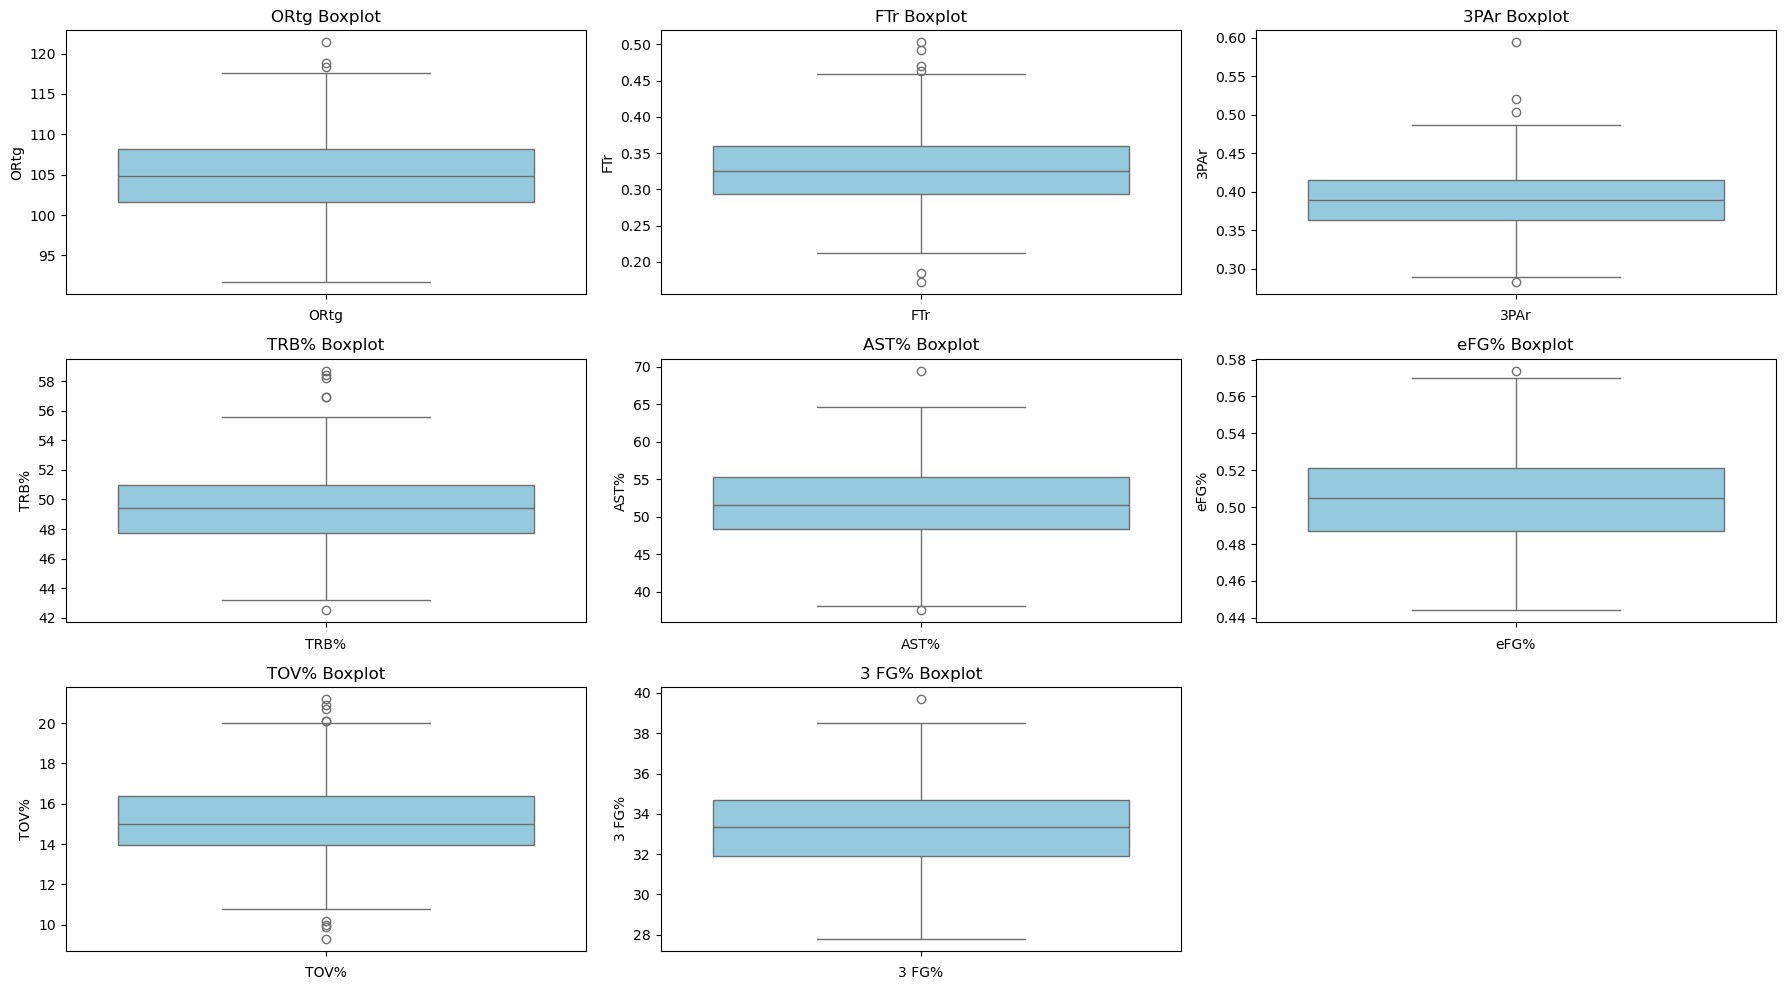

In [554]:
create_boxplots(trimmed_df)

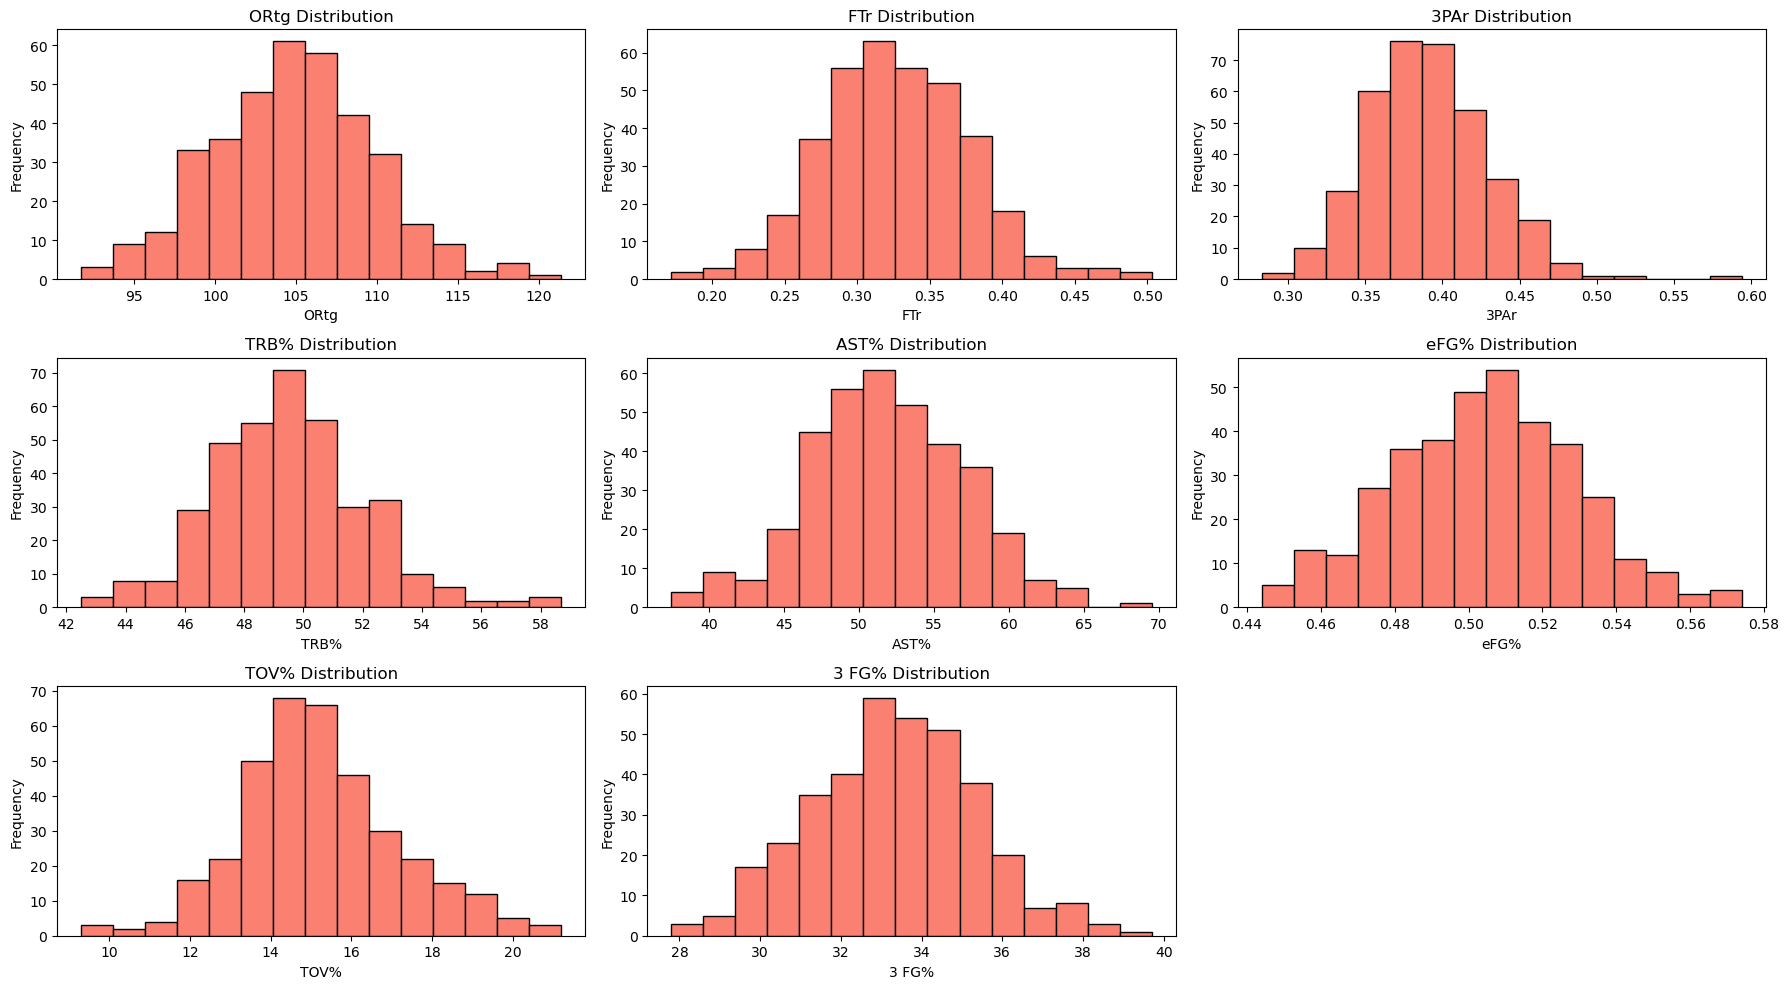

In [555]:
create_histograms(trimmed_df)

#### Visualize Scatterplot of Data

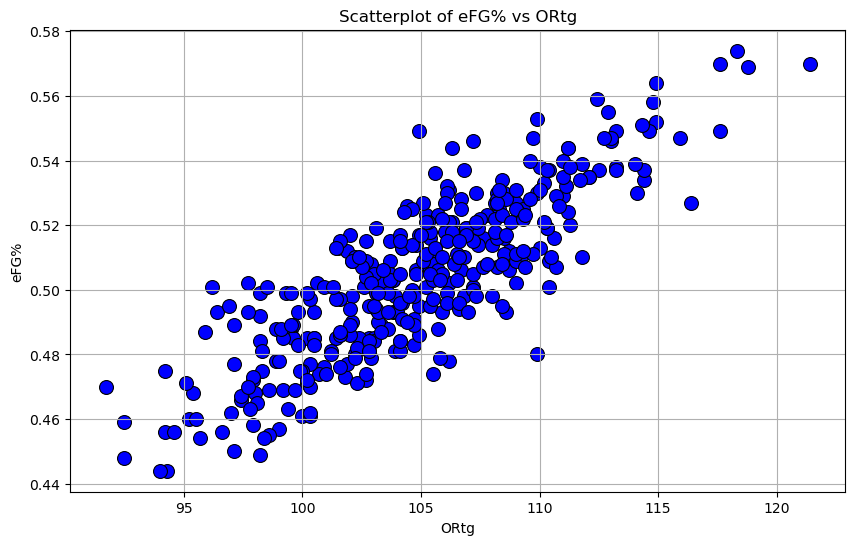

In [556]:
create_scatterplot(trimmed_df, 'ORtg', 'eFG%')

## Scale Data

In [557]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(trimmed_df)
scaled_df = pd.DataFrame(scaled_data, columns=trimmed_df.columns, index=trimmed_df.index)
scaled_df.head()

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%
School,,,,,,,,
Abilene Christian,-1.34,3.26,-1.18,0.15,-0.09,-0.21,2.86,-0.84
Air Force,1.63,0.53,-0.72,1.50,-0.63,1.68,-0.76,1.44
Akron,-0.36,-0.12,-0.22,-0.70,-1.37,-0.41,-0.05,-0.84
University of Alabama,0.26,0.10,-1.13,-1.16,-1.37,-1.06,-1.82,-1.51
Alabama A&M,0.26,2.81,-0.47,0.38,1.19,1.08,1.81,2.17


## Cluster Data

#### Set up & Analyze KMeans Clustering

In [558]:
## Set up Max K threshold for KMeans Clustering
max_k = 16

inertia = [] ## Set up Inertia list to hold inertia values for each k
silhouette_scores = [] ## Set up Silhouette Scores list to hold sil. scores for each k
k_values = range(2, max_k + 1) ## Set up k values range

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000) ## Initialize KMeans with k clusters
    cluster_labels = kmeans.fit_predict(scaled_df) ## Fit KMeans model and predict cluster labels
    sil_score = silhouette_score(scaled_df, cluster_labels) ## Calculate silhouette score
    silhouette_scores.append(sil_score) ## Append silhouette score to list
    inertia.append(kmeans.inertia_) ## Append inertia to list

#### Visualize Clusters & Silhouette Score

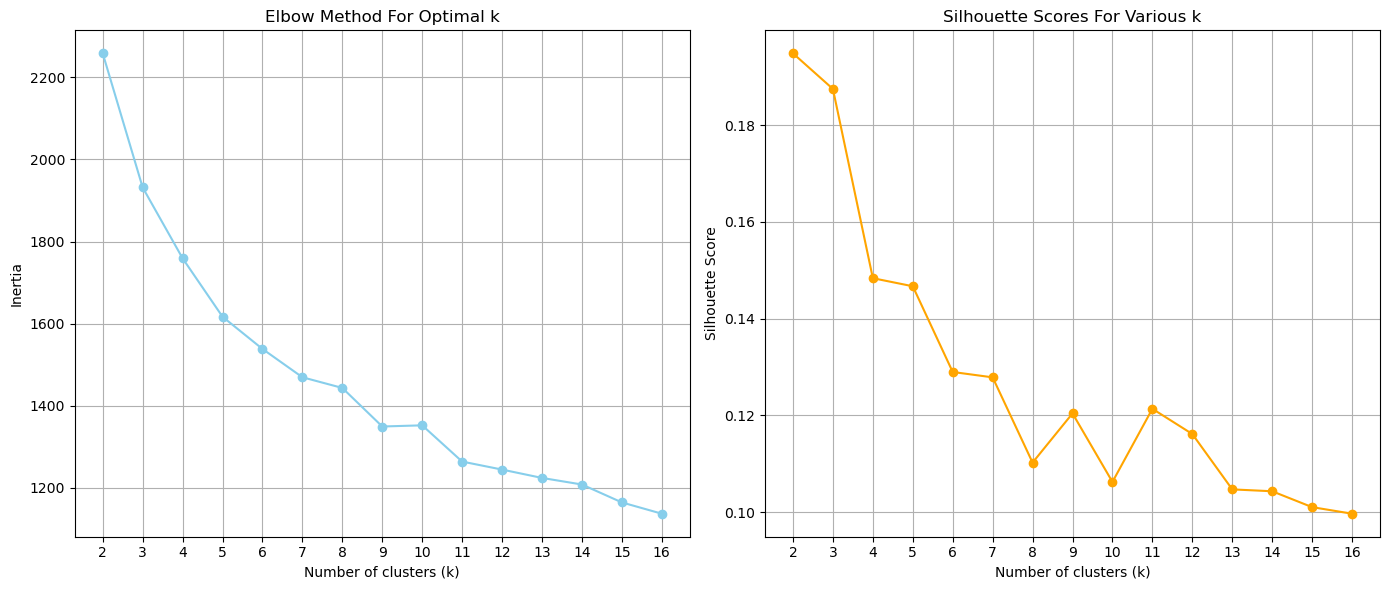

In [559]:
## Plot Inertia vs. k to visualize the elbow method
plt.figure(figsize=(14,6))

## Create inertia plot
plt.subplot(1,2,1)
plt.plot(k_values, inertia, marker='o', color='skyblue')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

## Create silhouette score plot
plt.subplot(1,2,2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores For Various k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

## Show plots
plt.tight_layout()
plt.show()

## Analyze Elbow Method Results

- Elbow Method shows that the ideal number of clusters is between 4 or 5
- Silhouette Scores show that 5 clusters would be a good balance
- Ideal Number of Clusters = 5

#### Instantiate Clustering Model

In [560]:
n_clusters = 5 ## Cluster Count Based on Elbow Method & Silhouette Scores
kmeans = KMeans(n_clusters=n_clusters, random_state=42, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_df)


#### Reassign Clusters to Original Dataframe

In [561]:
## Create cluster colummn in original dataframe
trimmed_df['Cluster'] = cluster_labels
trimmed_df.head()

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Cluster
School,,,,,,,,,
Abilene Christian,98.20,0.49,0.34,49.90,51.40,0.50,20.90,31.60,0
Air Force,113.00,0.35,0.36,53.40,48.60,0.55,13.70,36.30,3
Akron,103.10,0.32,0.38,47.70,44.80,0.49,15.10,31.60,2
University of Alabama,106.20,0.33,0.35,46.50,44.80,0.48,11.60,30.20,2
Alabama A&M,106.20,0.47,0.37,50.50,58.00,0.53,18.80,37.80,3


#### Merge in KenPom Height Data

In [562]:
## Merge Kenpom Height Data into Clustered df
cols_to_merge = ['Size', 'SizeRank', 'Hgt5', 'Hgt4','Hgt3', 'Hgt2', 'Hgt1']
trimmed_df = trimmed_df.merge(kenpomsize_df[cols_to_merge], left_index=True, right_index=True, how='left').copy()

## Preview Data
trimmed_df.head()

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Cluster,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1
School,,,,,,,,,,,,,,,,
Abilene Christian,98.20,0.49,0.34,49.90,51.40,0.50,20.90,31.60,0,77.31,163,-0.37,-0.84,-0.23,0.68,1.31
Air Force,113.00,0.35,0.36,53.40,48.60,0.55,13.70,36.30,3,78.18,46,1.08,-0.23,0.01,1.13,2.88
Akron,103.10,0.32,0.38,47.70,44.80,0.49,15.10,31.60,2,75.06,361,-1.94,-3.52,-2.16,-1.36,-1.75
University of Alabama,106.20,0.33,0.35,46.50,44.80,0.48,11.60,30.20,2,78.07,61,1.61,3.10,0.21,-0.47,-0.12
Alabama A&M,106.20,0.47,0.37,50.50,58.00,0.53,18.80,37.80,3,76.76,254,0.63,-0.25,-0.62,-0.37,-1.61


#### High Level Cluster Distribution

In [563]:
trimmed_df['Cluster'].value_counts()

Cluster
4    84
1    84
2    75
0    68
3    53
Name: count, dtype: int64

## Analyze Bellarmine Cluster

In [564]:
BU_Info = trimmed_df.loc[trimmed_df.index == 'Bellarmine']
BU_Info

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Cluster,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1
School,,,,,,,,,,,,,,,,
Bellarmine,117.60,0.34,0.46,53.50,54.70,0.57,13.40,38.50,3,76.51,294,-1.88,-0.67,-0.37,-0.30,-0.26


In [565]:
BU_ClusterNum = BU_Info['Cluster'].values[0]
BU_FullCluster = trimmed_df.loc[trimmed_df['Cluster'] == BU_ClusterNum].copy()
BU_FullCluster.sort_values(by='ORtg', ascending=True)

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Cluster,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1
School,,,,,,,,,,,,,,,,
Mercyhurst,105.60,0.39,0.39,55.20,54.80,0.54,19.00,34.90,3,75.04,362,-2.18,-1.27,-1.62,-2.89,-2.88
Alabama A&M,106.20,0.47,0.37,50.50,58.00,0.53,18.80,37.80,3,76.76,254,0.63,-0.25,-0.62,-0.37,-1.61
St Thomas,106.90,0.35,0.42,52.80,52.10,0.52,16.50,35.10,3,76.39,310,-0.97,-1.09,-0.85,-1.32,0.14
Northern Illinois,107.20,0.43,0.38,55.60,54.20,0.52,15.40,36.50,3,76.56,285,-1.17,-1.86,-0.16,0.19,-0.23
Seton Hall,107.20,0.40,0.44,52.20,59.20,0.55,19.40,36.40,3,78.27,41,-0.02,0.12,0.59,1.68,2.94
Colgate,107.30,0.26,0.40,50.80,53.40,0.53,14.40,37.50,3,77.22,177,0.38,-1.09,-0.21,0.26,0.74
Niagara,108.20,0.30,0.38,51.70,55.60,0.53,15.10,36.00,3,76.71,263,-0.12,-1.80,-0.45,-0.39,0.31
Texas San Antonio,108.30,0.42,0.38,54.00,57.70,0.53,18.40,35.30,3,76.52,290,0.06,-1.09,-0.22,-0.32,-1.86
Richmond,108.50,0.36,0.48,53.50,51.60,0.52,13.80,34.70,3,76.66,271,1.15,0.95,1.03,-2.75,-3.12


#### Summarize Bellarmine Cluster

In [566]:
## Describe everything except the Cluster column
print(f'Cluster {BU_ClusterNum} Summary Statistics:')
BU_FullCluster.describe().drop(columns=['Cluster'])

Cluster 3 Summary Statistics:


,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1
count,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00,53.00
mean,111.99,0.34,0.40,52.77,54.45,0.54,14.92,35.87,76.98,212.34,-0.44,-0.25,-0.13,-0.22,-0.12
std,3.39,0.06,0.03,2.01,3.78,0.01,1.79,1.51,0.86,104.33,1.07,1.10,1.00,1.14,1.63
min,105.60,0.22,0.33,48.10,46.00,0.51,11.30,32.20,74.87,15.00,-2.64,-2.09,-2.77,-2.89,-3.52
25%,109.90,0.30,0.38,51.70,51.60,0.53,13.70,34.80,76.46,141.00,-1.39,-1.09,-0.65,-0.74,-1.17
50%,111.70,0.35,0.40,52.50,54.70,0.54,14.80,35.90,76.81,245.00,-0.42,-0.32,-0.11,-0.15,-0.12
75%,114.10,0.37,0.42,53.50,57.50,0.55,15.70,37.10,77.41,299.00,0.28,0.58,0.62,0.41,0.93
max,121.40,0.50,0.52,58.40,63.70,0.57,19.40,39.70,78.77,363.00,1.90,2.55,1.79,1.98,2.94


## Analyze Overall Cluster Distribution

In [567]:
## Identify the Min, Max and Mean for each feature in each cluster
cluster_summary = trimmed_df.groupby('Cluster').agg(['min', 'max', 'mean'])
cluster_summary

ORtg                FTr           3PAr            TRB%              \
           min    max   mean  min  max mean  min  max mean   min   max  mean   
Cluster                                                                        
0        91.70 108.10 100.92 0.24 0.49 0.36 0.34 0.59 0.41 44.10 58.70 49.38   
1        99.50 111.80 106.06 0.24 0.39 0.31 0.34 0.48 0.41 43.20 52.60 48.74   
2        92.50 106.20  99.78 0.17 0.41 0.30 0.30 0.46 0.38 42.50 52.40 47.82   
3       105.60 121.40 111.99 0.22 0.50 0.34 0.33 0.52 0.40 48.10 58.40 52.77   
4       102.60 114.40 106.98 0.21 0.44 0.34 0.28 0.42 0.35 45.40 55.60 49.86   

         AST%             eFG%            TOV%             3 FG%              \
          min   max  mean  min  max mean   min   max  mean   min   max  mean   
Cluster                                                                        
0       48.00 69.50 56.23 0.45 0.55 0.50 14.90 21.20 17.80 29.50 35.70 32.56   
1       44.70 63.50 53.93 0.47 0.54 0.51 11.40 17.50 14.49 30.10 38.00 33.91   
2       39.30 56.10 48.57 0.44 0.50 0.47 10.00 18.50 14.95 27.80 34.60 31.26   
3       46.00 63.70 54.45 0.51 0.57 0.54 11.30 19.40 14.92 32.20 39.70 35.87   
4       37.50 56.20 47.58 0.48 0.54 0.51  9.30 17.90 14.24 29.90 37.50 33.59   

         Size             SizeRank              Hgt5             Hgt4       \
          min   max  mean      min  max   mean   min  max  mean   min  max   
Cluster                                                                      
0       75.15 79.33 77.13        4  359 192.76 -2.39 3.20 -0.13 -2.09 2.42   
1       74.27 79.69 77.28        2  364 171.19 -2.56 4.51  0.12 -3.45 2.22   
2       75.06 79.78 77.45        1  361 150.39 -1.97 3.45  0.48 -3.52 3.16   
3       74.87 78.77 76.98       15  363 212.34 -2.64 1.90 -0.44 -2.09 2.55   
4       75.31 78.91 77.11       10  357 195.35 -3.03 3.26 -0.17 -2.09 1.95   

               Hgt3             Hgt2             Hgt1             
         mean   min  max  mean   min  max  mean   min  max  mean  
Cluster                                                           
0       -0.14 -2.59 2.49 -0.11 -3.20 3.09 -0.03 -4.18 2.55  0.03  
1        0.04 -3.47 3.07  0.09 -4.04 2.68  0.08 -3.33 2.88  0.05  
2        0.43 -2.16 2.51  0.11 -3.30 2.68  0.17 -4.54 4.53  0.06  
3       -0.25 -2.77 1.79 -0.13 -2.89 1.98 -0.22 -3.52 2.94 -0.12  
4       -0.16 -2.02 1.90 -0.01 -2.46 2.61 -0.07 -3.12 2.48 -0.05

In [568]:
cluster_medians = trimmed_df.groupby('Cluster').median()
cluster_medians

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1
Cluster,,,,,,,,,,,,,,,
0,101.55,0.36,0.41,49.40,55.90,0.50,17.70,32.70,77.03,206.00,-0.33,-0.28,-0.10,-0.07,0.18
1,105.80,0.31,0.41,49.10,53.50,0.51,14.50,33.95,77.36,151.00,0.34,0.02,-0.03,0.27,0.24
2,100.20,0.31,0.38,47.60,48.70,0.47,14.90,31.30,77.39,146.00,0.40,0.49,0.08,0.12,0.08
3,111.70,0.35,0.40,52.50,54.70,0.54,14.80,35.90,76.81,245.00,-0.42,-0.32,-0.11,-0.15,-0.12
4,106.65,0.34,0.35,49.80,47.90,0.51,14.20,33.60,77.05,203.00,-0.18,-0.18,0.02,-0.11,0.20


In [569]:
# default: higher = worse → ascending=True
ascending_map = {col: True for col in cluster_medians.columns}

# exception: for TOV%, higher = better → ascending=False
ascending_map['TOV%'] = False

cluster_ranks = cluster_medians.rank(ascending=ascending_map).astype(int)
cluster_ranks = cluster_ranks.drop(['Hgt5', 'Hgt4', 'Hgt3', 'Hgt2', 'Hgt1'], axis=1)
cluster_ranks

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Size,SizeRank
Cluster,,,,,,,,,,
0,2,5,4,3,5,2,5,2,2,4
1,3,1,5,2,3,4,2,4,4,2
2,1,1,2,1,2,1,4,1,5,1
3,5,4,3,5,4,5,3,5,1,5
4,4,3,1,4,1,3,1,3,3,3


#### Visualize Cluster Distribution

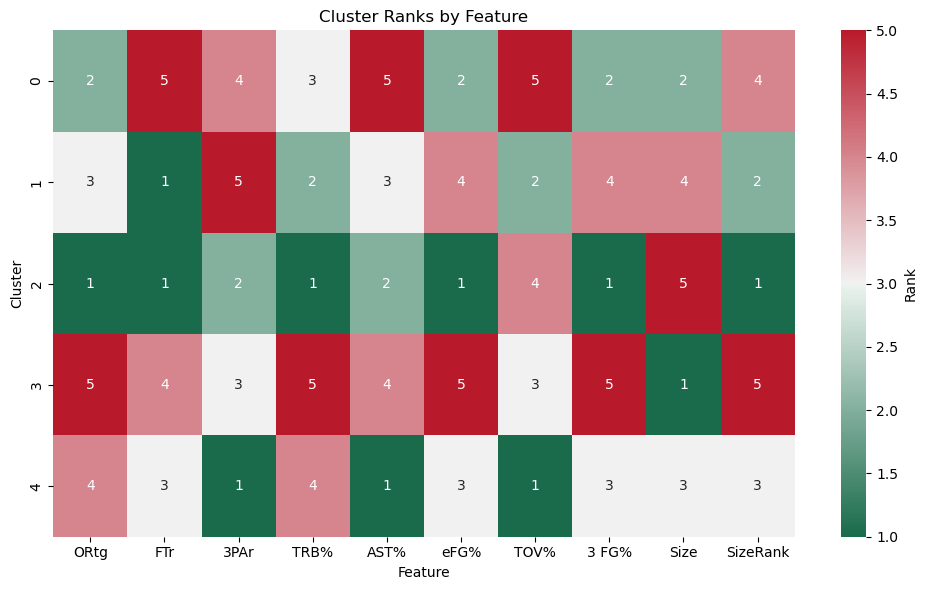

In [570]:
plt.figure(figsize=(10,6))
sns.heatmap(
    cluster_ranks, 
    annot=True, fmt="d",  # show rank numbers inside cells
    cmap=sns.diverging_palette(150, 10, s=90, l=40, as_cmap=True),      # reversed so lower rank (1) is darker
    cbar_kws={'label': 'Rank'}
)

plt.title("Cluster Ranks by Feature")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

In [571]:
## Group by cluster and calculate mean for each feature
cluster_means = trimmed_df.groupby('Cluster').mean()
cluster_means

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1
Cluster,,,,,,,,,,,,,,,
0,100.92,0.36,0.41,49.38,56.23,0.50,17.80,32.56,77.13,192.76,-0.13,-0.14,-0.11,-0.03,0.03
1,106.06,0.31,0.41,48.74,53.93,0.51,14.49,33.91,77.28,171.19,0.12,0.04,0.09,0.08,0.05
2,99.78,0.30,0.38,47.82,48.57,0.47,14.95,31.26,77.45,150.39,0.48,0.43,0.11,0.17,0.06
3,111.99,0.34,0.40,52.77,54.45,0.54,14.92,35.87,76.98,212.34,-0.44,-0.25,-0.13,-0.22,-0.12
4,106.98,0.34,0.35,49.86,47.58,0.51,14.24,33.59,77.11,195.35,-0.17,-0.16,-0.01,-0.07,-0.05


In [572]:
## Merge winloss data with trimmed_df to get W and L columns
final_df = trimmed_df.merge(full_data[['W', 'L', 'Conf']], left_index=True, right_index=True, how='left')
final_df['WinPCT'] = final_df['W'] / (final_df['W'] + final_df['L'])

final_df.head()

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Cluster,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1,W,L,Conf,WinPCT
School,,,,,,,,,,,,,,,,,,,,
Abilene Christian,98.20,0.49,0.34,49.90,51.40,0.50,20.90,31.60,0,77.31,163,-0.37,-0.84,-0.23,0.68,1.31,16,16,WAC,0.50
Air Force,113.00,0.35,0.36,53.40,48.60,0.55,13.70,36.30,3,78.18,46,1.08,-0.23,0.01,1.13,2.88,4,28,MWC,0.12
Akron,103.10,0.32,0.38,47.70,44.80,0.49,15.10,31.60,2,75.06,361,-1.94,-3.52,-2.16,-1.36,-1.75,28,7,MAC,0.80
University of Alabama,106.20,0.33,0.35,46.50,44.80,0.48,11.60,30.20,2,78.07,61,1.61,3.10,0.21,-0.47,-0.12,28,9,SEC,0.76
Alabama A&M,106.20,0.47,0.37,50.50,58.00,0.53,18.80,37.80,3,76.76,254,0.63,-0.25,-0.62,-0.37,-1.61,10,22,SWAC,0.31


In [573]:
## Group by cluster and calculate average wins, average losses and mean WinPCT for each cluster
cluster_performance = final_df.groupby('Cluster').agg({
    'W': 'mean',
    'L': 'mean',
    'WinPCT': 'mean',
    'Size': 'median',
    'SizeRank': 'median'
}).rename(columns={
    'W': 'Avg Wins',
    'L': 'Avg Losses',
    'WinPCT': 'Avg WinPCT',
    'Size':'MedianSize',
    'SizeRank': 'MedianSizeRank'
})
cluster_performance.sort_values(by='Avg WinPCT', ascending=False)

,Avg Wins,Avg Losses,Avg WinPCT,MedianSize,MedianSizeRank
Cluster,,,,,
2,23.11,11.35,0.67,77.39,146.00
0,19.26,13.94,0.58,77.03,206.00
1,16.96,16.15,0.51,77.36,151.00
4,15.69,17.06,0.48,77.05,203.00
3,9.43,22.28,0.30,76.81,245.00


## Filter Down to ASUN and Analyze

In [574]:
final_df['Conf'].value_counts()

Conf
Big Ten      18
ACC          18
SEC          16
Big 12       16
A-10         15
Sun Belt     14
CAA          14
AAC          13
MAAC         13
MAC          12
A-Sun        12
MVC          12
SWAC         12
Southland    12
WCC          11
Big East     11
Big West     11
MWC          11
OVC          11
Horizon      11
CUSA         10
Big Sky      10
Patriot      10
Southern     10
Summit        9
AEC           9
Big South     9
NEC           9
WAC           9
MEAC          8
Ivy           8
Name: count, dtype: int64

In [575]:
## Filter final_df down to ASUN teams only
asun_df = final_df[final_df['Conf'] == 'A-Sun'].copy()
asun_df.sort_values(by='Cluster', ascending=True)

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Cluster,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1,W,L,Conf,WinPCT
School,,,,,,,,,,,,,,,,,,,,
Florida Gulf Coast,106.20,0.29,0.43,47.40,49.80,0.50,12.50,35.00,1,77.66,110,2.05,0.69,0.69,-1.04,-0.12,19,15,A-Sun,0.56
North Alabama,103.60,0.27,0.43,47.60,51.30,0.50,14.70,31.90,1,76.03,340,-0.80,-0.66,-0.73,-2.56,-1.12,24,11,A-Sun,0.69
Lipscomb,99.20,0.21,0.37,48.90,39.30,0.48,14.30,30.50,2,76.71,264,0.55,0.56,-2.10,-0.34,-1.12,25,10,A-Sun,0.71
Austin Peay,110.20,0.36,0.36,53.20,51.60,0.53,15.20,36.50,3,76.13,334,-1.05,-1.13,-2.77,-1.32,0.88,14,19,A-Sun,0.42
Bellarmine,117.60,0.34,0.46,53.50,54.70,0.57,13.40,38.50,3,76.51,294,-1.88,-0.67,-0.37,-0.30,-0.26,5,26,A-Sun,0.16
Central Arkansas,112.40,0.22,0.52,50.70,60.80,0.56,14.80,38.20,3,76.94,216,0.08,0.77,0.14,-0.65,-1.65,9,24,A-Sun,0.27
Stetson,116.40,0.27,0.41,53.50,55.30,0.53,11.30,36.00,3,77.81,89,1.28,0.58,0.90,1.17,-0.88,8,24,A-Sun,0.25
West Georgia,112.90,0.36,0.43,52.60,57.50,0.56,14.90,35.90,3,76.38,311,-1.67,-1.09,0.35,-0.19,-1.52,6,25,A-Sun,0.19
Eastern Kentucky,107.80,0.31,0.37,50.30,49.40,0.52,16.00,35.30,4,76.79,247,-0.81,-0.08,0.32,-0.38,-1.14,18,14,A-Sun,0.56


In [576]:
print(asun_df.value_counts('Cluster', normalize=False))
print(asun_df.value_counts('Cluster', normalize=True))

Cluster
3    5
4    4
1    2
2    1
Name: count, dtype: int64
Cluster
3   0.42
4   0.33
1   0.17
2   0.08
Name: proportion, dtype: float64


In [577]:
## Group by cluster and calculate average wins, average losses and mean WinPCT for each cluster
asun_cluster_performance = asun_df.groupby('Cluster').agg({
    'W': 'median',
    'L': 'median',
    'WinPCT': 'median',
    'Size': 'median',
    'SizeRank': 'median'
}).rename(columns={
    'W': 'Avg Wins',
    'L': 'Avg Losses',
    'WinPCT': 'Median WinPCT',
    'Size':'MedianSize',
    'SizeRank': 'MedianSizeRank'
})
asun_cluster_performance.sort_values(by='Median WinPCT', ascending=False)

,Avg Wins,Avg Losses,Median WinPCT,MedianSize,MedianSizeRank
Cluster,,,,,
2,25.00,10.00,0.71,76.71,264.00
1,21.50,13.00,0.62,76.84,225.00
4,18.50,14.50,0.57,77.10,194.50
3,8.00,24.00,0.25,76.51,294.00


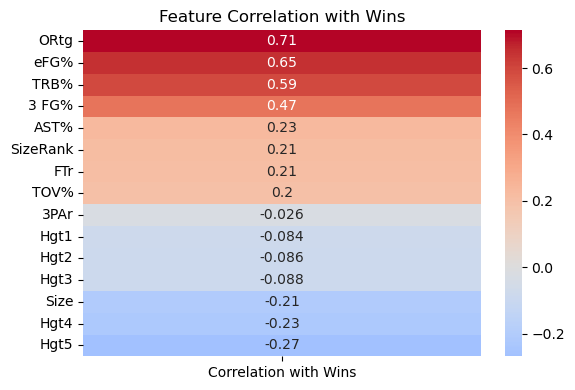

ORtg        0.71
eFG%        0.65
TRB%        0.59
3 FG%       0.47
AST%        0.23
SizeRank    0.21
FTr         0.21
TOV%        0.20
3PAr       -0.03
Hgt1       -0.08
Hgt2       -0.09
Hgt3       -0.09
Size       -0.21
Hgt4       -0.23
Hgt5       -0.27
dtype: float64


In [578]:
## Determine the correlation between the feature and Wins
wins_correlation = (final_df
                    .drop(columns=['WinPCT', 'L', 'Conf', 'Cluster'])
                    .corrwith(final_df['W']))


## Multiply everything in wins_correlation by -1 except W and TOV%
for col in wins_correlation.index:
    if col not in ['W', 'TOV%']:
        wins_correlation[col] *= -1

wins_correlation = (wins_correlation
                    .drop(index=['W'])  # Drop W itself from the correlation list
                    .sort_values(ascending=False))

## Visualize the correlation with a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(data=wins_correlation.to_frame(name='Correlation with Wins'), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation with Wins')
plt.tight_layout()
plt.show()

print(wins_correlation)

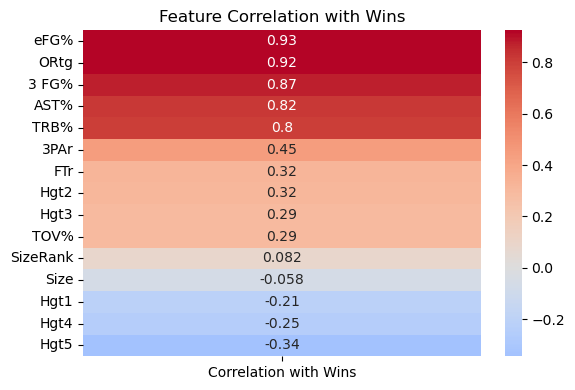

eFG%        0.93
ORtg        0.92
3 FG%       0.87
AST%        0.82
TRB%        0.80
3PAr        0.45
FTr         0.32
Hgt2        0.32
Hgt3        0.29
TOV%        0.29
SizeRank    0.08
Size       -0.06
Hgt1       -0.21
Hgt4       -0.25
Hgt5       -0.34
dtype: float64


In [579]:
## Determine the correlation between the feature and Wins
asun_wins_correlation = (asun_df
                    .drop(columns=['WinPCT', 'L', 'Conf', 'Cluster'])
                    .corrwith(final_df['W']))


## Multiply everything in wins_correlation by -1 except W and TOV%
for col in asun_wins_correlation.index:
    if col not in ['W', 'TOV%']:
        asun_wins_correlation[col] *= -1

asun_wins_correlation = (asun_wins_correlation
                    .drop(index=['W'])  # Drop W itself from the correlation list
                    .sort_values(ascending=False))

## Visualize the correlation with a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(data=asun_wins_correlation.to_frame(name='Correlation with Wins'), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation with Wins')
plt.tight_layout()
plt.show()

print(asun_wins_correlation)

In [580]:
BU_Info

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Cluster,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1
School,,,,,,,,,,,,,,,,
Bellarmine,117.60,0.34,0.46,53.50,54.70,0.57,13.40,38.50,3,76.51,294,-1.88,-0.67,-0.37,-0.30,-0.26


#### Subset Data to Find Teams With Similar Size Ranking as Bellarmine

In [581]:
height_subset = trimmed_df.copy()

BellarmineSize = BU_Info['SizeRank'].iloc[0]
approx_size_lower = (BellarmineSize * .90)
approx_size_upper = (BellarmineSize * 1.10)
lower_condition = height_subset['SizeRank'] > approx_size_lower
upper_condition = height_subset['SizeRank'] < approx_size_upper

height_subset = height_subset.loc[lower_condition & upper_condition]
height_subset.sort_values(by='eFG%', ascending=True)

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Cluster,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1
School,,,,,,,,,,,,,,,,
New Mexico State,97.90,0.39,0.43,47.20,52.30,0.46,14.20,28.70,2,76.46,301,0.37,-0.21,-1.54,-1.32,-1.05
Nicholls State,100.20,0.34,0.37,49.90,49.60,0.47,15.40,29.40,2,76.59,281,-1.39,-0.36,-0.51,-0.64,-0.19
Texas Southern,99.90,0.34,0.42,50.90,55.60,0.47,16.60,33.10,0,76.32,315,0.12,-0.21,-0.38,-1.29,-2.66
Texas Tech,101.20,0.33,0.35,46.90,46.30,0.48,14.90,32.10,2,76.54,289,0.52,-1.09,-0.51,-0.82,-1.42
Dartmouth,99.60,0.23,0.38,49.00,50.70,0.48,12.90,29.50,2,76.40,309,-1.39,-0.61,0.16,-0.58,-1.60
Ohio State,104.90,0.40,0.38,50.30,47.90,0.49,14.60,30.40,4,76.68,269,0.00,-1.09,0.21,-1.34,-0.43
Memphis,102.00,0.34,0.41,47.90,54.20,0.49,16.20,32.10,0,76.49,295,0.52,-0.44,-1.95,-0.65,-1.04
NJIT,108.60,0.38,0.35,51.40,50.20,0.49,11.90,30.50,4,76.59,282,-1.55,-0.71,0.49,-0.19,-1.12
East Tennessee State,100.50,0.33,0.41,47.30,50.00,0.49,16.70,33.60,0,76.65,272,-0.05,-0.98,-0.54,-1.07,-0.12


#### Find Teams from Subset Within Top Performing Cluster (Cluster 2)

In [582]:
cluster_filter = height_subset['Cluster'] == 2
height_subset = height_subset.loc[cluster_filter].sort_values(by='eFG%', ascending=True)
height_subset

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Cluster,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1
School,,,,,,,,,,,,,,,,
New Mexico State,97.90,0.39,0.43,47.20,52.30,0.46,14.20,28.70,2,76.46,301,0.37,-0.21,-1.54,-1.32,-1.05
Nicholls State,100.20,0.34,0.37,49.90,49.60,0.47,15.40,29.40,2,76.59,281,-1.39,-0.36,-0.51,-0.64,-0.19
Texas Tech,101.20,0.33,0.35,46.90,46.30,0.48,14.90,32.10,2,76.54,289,0.52,-1.09,-0.51,-0.82,-1.42
Dartmouth,99.60,0.23,0.38,49.00,50.70,0.48,12.90,29.50,2,76.40,309,-1.39,-0.61,0.16,-0.58,-1.60
FDU,104.20,0.29,0.37,52.30,50.10,0.50,15.60,29.90,2,76.21,323,-1.97,-1.28,-1.24,-0.37,-0.12


In [583]:
# Display WinLoss data for teams in height_subset
winloss_cols = ['W', 'L']
height_winloss = final_df.loc[height_subset.index, winloss_cols]
height_winloss

,W,L
School,,
New Mexico State,17,15
Nicholls State,20,13
Texas Tech,28,9
Dartmouth,14,14
FDU,13,20


## Cluster Teams by Size Makeup

In [584]:
## Filter to height only data
cols_to_keep = ["Size","Hgt5","Hgt4","Hgt3","Hgt2","Hgt1"]
height_data = trimmed_df[cols_to_keep]
height_data

,Size,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1
School,,,,,,
Abilene Christian,77.31,-0.37,-0.84,-0.23,0.68,1.31
Air Force,78.18,1.08,-0.23,0.01,1.13,2.88
Akron,75.06,-1.94,-3.52,-2.16,-1.36,-1.75
University of Alabama,78.07,1.61,3.10,0.21,-0.47,-0.12
Alabama A&M,76.76,0.63,-0.25,-0.62,-0.37,-1.61
...,...,...,...,...,...,...
Wright State,76.63,-1.40,-0.71,0.22,-0.54,-0.44
Wyoming,77.74,0.29,0.15,0.90,0.41,0.91
Xavier,77.31,0.07,0.91,0.25,0.07,-0.77


In [585]:
scaled_height_data = scaler.fit_transform(height_data)
scaled_height_df = pd.DataFrame(scaled_height_data, columns=height_data.columns, index=height_data.index)
scaled_height_df.head()

,Size,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1
School,,,,,,
Abilene Christian,0.12,-0.30,-0.78,-0.22,0.58,0.90
Air Force,1.12,0.86,-0.21,0.01,0.96,1.97
Akron,-2.46,-1.55,-3.29,-2.07,-1.16,-1.20
University of Alabama,0.99,1.29,2.90,0.20,-0.40,-0.08
Alabama A&M,-0.51,0.50,-0.23,-0.59,-0.31,-1.10


In [586]:
## Set up Max K threshold for KMeans Clustering
max_k = 16

inertia = [] ## Set up Inertia list to hold inertia values for each k
silhouette_scores = [] ## Set up Silhouette Scores list to hold sil. scores for each k
k_values = range(2, max_k + 1) ## Set up k values range

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000) ## Initialize KMeans with k clusters
    height_cluster_labels = kmeans.fit_predict(scaled_height_df) ## Fit KMeans model and predict cluster labels
    sil_score = silhouette_score(scaled_height_df, height_cluster_labels) ## Calculate silhouette score
    silhouette_scores.append(sil_score) ## Append silhouette score to list
    inertia.append(kmeans.inertia_) ## Append inertia to list

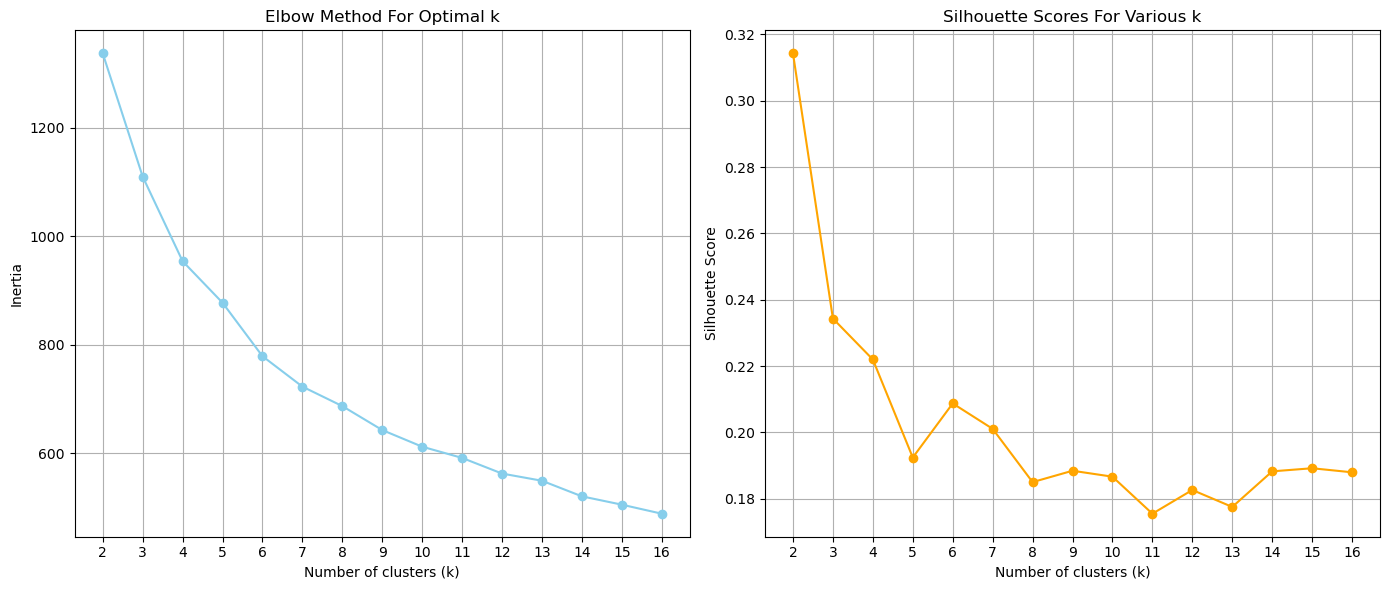

In [587]:
## Plot Inertia vs. k to visualize the elbow method
plt.figure(figsize=(14,6))

## Create inertia plot
plt.subplot(1,2,1)
plt.plot(k_values, inertia, marker='o', color='skyblue')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

## Create silhouette score plot
plt.subplot(1,2,2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores For Various k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

## Show plots
plt.tight_layout()
plt.show()

In [588]:
n_height_clusters = 6 ## Cluster Count Based on Elbow Method & Silhouette Scores
kmeans = KMeans(n_clusters=n_height_clusters, random_state=42, max_iter=1000)

height_cluster_labels = kmeans.fit_predict(scaled_height_df)

In [589]:
## Create cluster colummn in original dataframe
final_df['HeightCluster'] = height_cluster_labels
final_df.head()

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Cluster,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1,W,L,Conf,WinPCT,HeightCluster
School,,,,,,,,,,,,,,,,,,,,,
Abilene Christian,98.20,0.49,0.34,49.90,51.40,0.50,20.90,31.60,0,77.31,163,-0.37,-0.84,-0.23,0.68,1.31,16,16,WAC,0.50,1
Air Force,113.00,0.35,0.36,53.40,48.60,0.55,13.70,36.30,3,78.18,46,1.08,-0.23,0.01,1.13,2.88,4,28,MWC,0.12,1
Akron,103.10,0.32,0.38,47.70,44.80,0.49,15.10,31.60,2,75.06,361,-1.94,-3.52,-2.16,-1.36,-1.75,28,7,MAC,0.80,0
University of Alabama,106.20,0.33,0.35,46.50,44.80,0.48,11.60,30.20,2,78.07,61,1.61,3.10,0.21,-0.47,-0.12,28,9,SEC,0.76,4
Alabama A&M,106.20,0.47,0.37,50.50,58.00,0.53,18.80,37.80,3,76.76,254,0.63,-0.25,-0.62,-0.37,-1.61,10,22,SWAC,0.31,3


In [590]:
BU_Height_Cluster = final_df['HeightCluster'].loc['Bellarmine']
BU_Height_Cluster

np.int32(2)

#### Subset Data to Similar Height Cluster (Cluster 2)

In [591]:
height_filter_condition = final_df['HeightCluster'] == BU_Height_Cluster
heightclustersubset_df = final_df.loc[height_filter_condition]
len(heightclustersubset_df)

78

#### Subset Further Showing Highest Performing Defensive Metrics Cluster (Cluster 2)

In [592]:
best_winpct_cluster = 2
best_winpct_cluster_condition = final_df['Cluster'] == best_winpct_cluster
winpct_and_height_cluster_df = heightclustersubset_df.loc[best_winpct_cluster_condition]

In [593]:
height_cluster_summary = final_df.groupby('HeightCluster').agg({
    'SizeRank': 'median',
    'Hgt1': 'median',
    'Hgt2': 'median',
    'Hgt3': 'median',
    'Hgt4': 'median',
    'Hgt5': 'median',
    'W': 'median',
    'L': 'median',
    'WinPCT': 'median'
}).rename(columns={
    'SizeRank': 'Median SizeRank',
    'Hgt1': 'Median Hgt1',
    'Hgt2': 'Median Hgt2',
    'Hgt3': 'Median Hgt3',
    'Hgt4': 'Median Hgt4',
    'Hgt5': 'Median Hgt5',
    'W': 'Median W',
    'L': 'Median L',
    'WinPCT': 'Median WinPCT'
}).sort_values(by='Median WinPCT', ascending=False)

height_cluster_summary

,Median SizeRank,Median Hgt1,Median Hgt2,Median Hgt3,Median Hgt4,Median Hgt5,Median W,Median L,Median WinPCT
HeightCluster,,,,,,,,,
5,22.50,1.19,1.29,1.40,1.61,1.50,19.00,14.50,0.58
4,142.50,-0.23,0.04,0.15,0.67,0.61,18.50,15.00,0.55
3,281.50,-1.10,-1.02,-0.86,-0.43,0.28,17.00,15.00,0.54
1,103.00,1.40,0.99,0.59,-0.02,-0.42,17.00,16.00,0.53
0,355.00,-2.89,-2.49,-1.71,-1.27,-1.61,17.00,16.00,0.52
2,264.50,0.08,-0.28,-0.43,-0.76,-1.39,14.00,19.00,0.44


In [594]:
trimmed_winpct_and_height_cluster_df = winpct_and_height_cluster_df.copy()
trimmed_winpct_and_height_cluster_df.drop(['Cluster','HeightCluster','Conf'], axis=1, inplace=True)
trimmed_winpct_and_height_cluster_df.sort_values(by='WinPCT', ascending=False)

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1,W,L,WinPCT
School,,,,,,,,,,,,,,,,,,
Robert Morris,101.30,0.30,0.36,46.60,51.70,0.50,16.40,32.80,76.89,224,-0.66,-0.26,-0.10,0.00,-0.53,26,9,0.74
Arkansas State,99.00,0.37,0.34,48.10,48.50,0.46,14.70,30.00,76.97,212,-0.28,-0.56,-0.47,0.06,0.09,25,11,0.69
Marist,99.20,0.33,0.35,47.30,45.10,0.47,14.40,33.60,76.85,237,-1.15,-0.55,-0.16,-0.17,0.24,20,10,0.67
Nicholls State,100.20,0.34,0.37,49.90,49.60,0.47,15.40,29.40,76.59,281,-1.39,-0.36,-0.51,-0.64,-0.19,20,13,0.61
Dartmouth,99.60,0.23,0.38,49.00,50.70,0.48,12.90,29.50,76.40,309,-1.39,-0.61,0.16,-0.58,-1.60,14,14,0.50
Hofstra,98.40,0.37,0.40,50.10,53.20,0.45,14.40,33.60,77.04,205,0.01,-0.91,-1.50,-0.32,1.88,15,18,0.45
FDU,104.20,0.29,0.37,52.30,50.10,0.50,15.60,29.90,76.21,323,-1.97,-1.28,-1.24,-0.37,-0.12,13,20,0.39


In [600]:
bellarmine_row = final_df.loc[['Bellarmine']]
bellarmine_row

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Cluster,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1,W,L,Conf,WinPCT,HeightCluster
School,,,,,,,,,,,,,,,,,,,,,
Bellarmine,117.60,0.34,0.46,53.50,54.70,0.57,13.40,38.50,3,76.51,294,-1.88,-0.67,-0.37,-0.30,-0.26,5,26,A-Sun,0.16,2


In [601]:
bu_row = bellarmine_row.drop(['Cluster','HeightCluster','Conf'], axis=1)
bu_row

,ORtg,FTr,3PAr,TRB%,AST%,eFG%,TOV%,3 FG%,Size,SizeRank,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1,W,L,WinPCT
School,,,,,,,,,,,,,,,,,,
Bellarmine,117.60,0.34,0.46,53.50,54.70,0.57,13.40,38.50,76.51,294,-1.88,-0.67,-0.37,-0.30,-0.26,5,26,0.16
